# Bouncing Ball

This example demonstrates PathSim's event handling system. The classical example here is the bouncing ball. The ball accelerates downward due to gravity and once it hits the floor, it bounces back. The dynamics of this system are discontinuous due to the jump in velocity (sign change) exactly at the bounce. This is called a discrete event, specifically a zero crossing event.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/examples_event/example_bouncingball.py).

Systems like this require the location and resolution of discrete events within the timestep and are not easily solved with standard numerical ODE solvers. PathSim implements an event management system that can track the system state and locate and resolve specified events.

We can translate the dynamics of the system into a block diagram. Note the event manager that watches the state of the integrator for the position and can act on both integrator states:

## Import and Setup

To simulate the bouncing ball, let's start by importing the required blocks from the block library. In this case integrators and a constant for gravity.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Integrator, Constant, Scope
from pathsim.events import ZeroCrossing

## System Parameters

Then define the system parameters:

In [7]:
# Gravitational acceleration
g = 9.81

# Elasticity of bounce (energy loss factor)
b = 0.9

# Initial conditions (position and velocity)
x0, v0 = 1, 5

## System Definition

Now we can construct the system by instantiating the blocks we need (from the block diagram above) with their corresponding parameters and collect them together in a list:

In [10]:
# Blocks that define the system
Ix = Integrator(x0)     # v -> x
Iv = Integrator(v0)     # a -> v 
Cn = Constant(-g)       # gravitational acceleration
Sc = Scope(labels=["x", "v"])

blocks = [Ix, Iv, Cn, Sc]

# The connections between the blocks
connections = [
    Connection(Cn, Iv),
    Connection(Iv, Ix),
    Connection(Ix, Sc[0])
]

## Event Handling

Now the continuous system dynamics are defined. Without any additions, the ball would just accelerate indefinitely even past the floor. To implement the bounce, we need to define a zero crossing event tracker that watches the position and can detect when it changes its sign.

In PathSim events are defined by their type and an event function that is evaluated to determine whether an event has occurred and how close to the timestep it is and an action function that gets called to resolve the event once it is located to sufficient accuracy.

Here the event function just watches the state of the integrator `Ix`, i.e. the position and if it crosses the origin, the action function flips the sign of the velocity, i.e. the state of integrator `Iv` multiplied by the elasticity constant (loses some energy at the bounce):

In [13]:
# Event function for zero crossing detection
def func_evt(t):
    *_, x = Ix()  # Get block outputs and states
    return x

# Action function for state transformation
def func_act(t):
    *_, x = Ix()
    *_, v = Iv()
    Ix.engine.set(abs(x))
    Iv.engine.set(-b*v)

# Events (zero crossing)
E1 = ZeroCrossing(
    func_evt=func_evt,                 
    func_act=func_act, 
    tolerance=1e-4
)

events = [E1]

## Simulation Setup and Execution

Now the hybrid dynamical system consisting of the blocks, connections and discrete events is fully defined. Next, we can initialize the simulation and set some tolerances.

In [16]:
from pathsim.solvers import RKBS32
             
# Initialize simulation
Sim = Simulation(
    blocks, 
    connections, 
    events, 
    dt=0.01, 
    dt_max=0.04,
    log=True, 
    Solver=RKBS32, 
    tolerance_lte_rel=1e-5, 
    tolerance_lte_abs=1e-7
)

# Run the simulation
Sim.run(10)

2025-10-11 09:27:35,003 - INFO - LOGGING (log: True)
2025-10-11 09:27:35,004 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-11 09:27:35,004 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-10-11 09:27:35,005 - INFO - BLOCK (type: Constant, dynamic: False, events: 0)
2025-10-11 09:27:35,005 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-11 09:27:35,005 - INFO - GRAPH (size: 4, alg. depth: 1, loop depth: 0, runtime: 0.072ms)
2025-10-11 09:27:35,006 - INFO - STARTING -> TRANSIENT (Duration: 10.00s)
2025-10-11 09:27:35,006 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-11 09:27:35,014 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 64 steps (8837.5 steps/s)
2025-10-11 09:27:35,023 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: --:--:--) | 141 steps (8896.6 steps/s)
2025-10-11 09:27:35,031 - INFO - TRANSIENT:  60% | elapsed: 00:00:00 (eta: --:--:--) | 217 steps (9340.5 step

{'total_steps': 415, 'successful_steps': 363, 'runtime_ms': 46.96499998681247}

## Results

Due to the object-oriented and decentralized architecture of PathSim, the scope block holds the time series data directly. Reading the recorded data is as easy as:

In [19]:
# Read the recordings from the scope directly
time, [data_x] = Sc.read()

And plotting the results in an external matplotlib window is also straightforward:

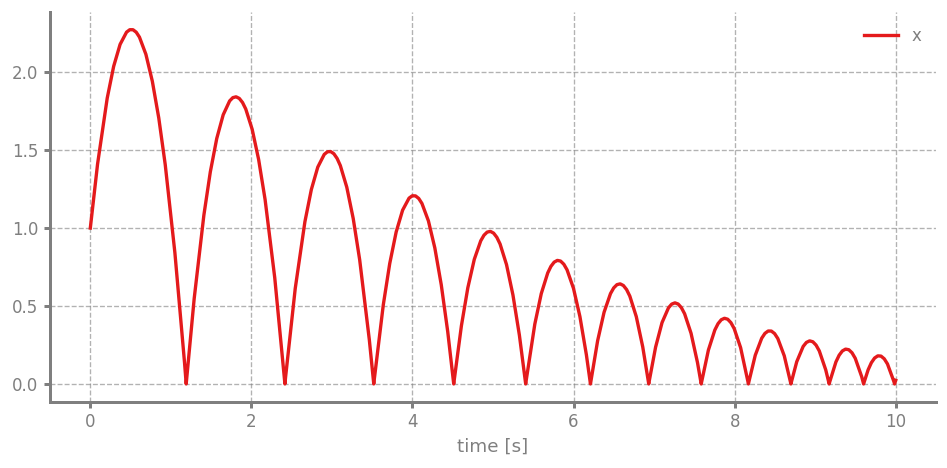

In [22]:
# Plot the recordings from the scope
fig, ax = Sc.plot("-", lw=2)
plt.show()

We can also add the detected events to the plot by just iterating the event instance:

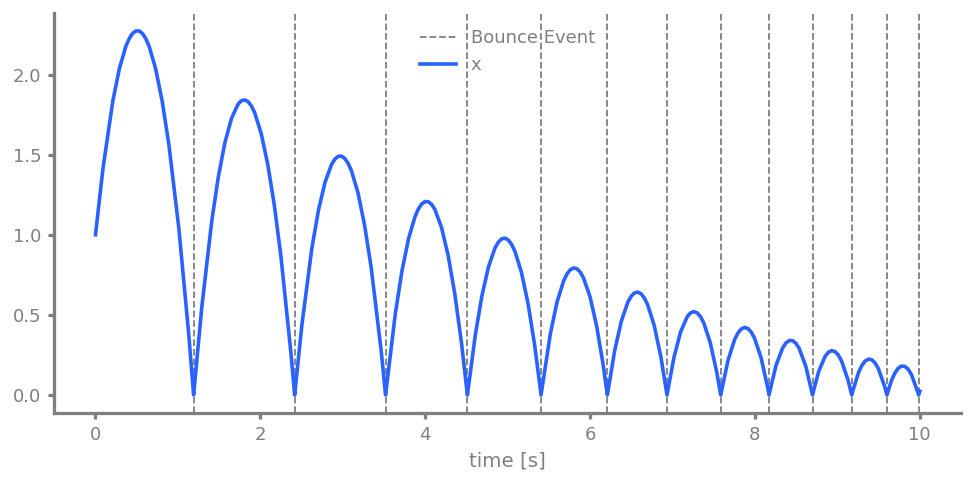

In [53]:
time, [data_x] = Sc.read()
fig, ax = plt.subplots(figsize=(9, 4), dpi=130)
for t in E1: 
    ax.axvline(t, ls="--", lw=1, c="gray", label="Bounce Event" if t == list(E1)[0] else None)
ax.plot(time, data_x, label="x")
ax.set_xlabel("time [s]")
ax.legend()
plt.show()

## Timestep Evolution

For educational purposes it might be interesting to have a look at the evolution of the timestep.

We can clearly see how the adaptive integrator in combination with the event handling system approaches the event location with smaller steps and once located takes larger steps again until the next event is in sight. And so on.

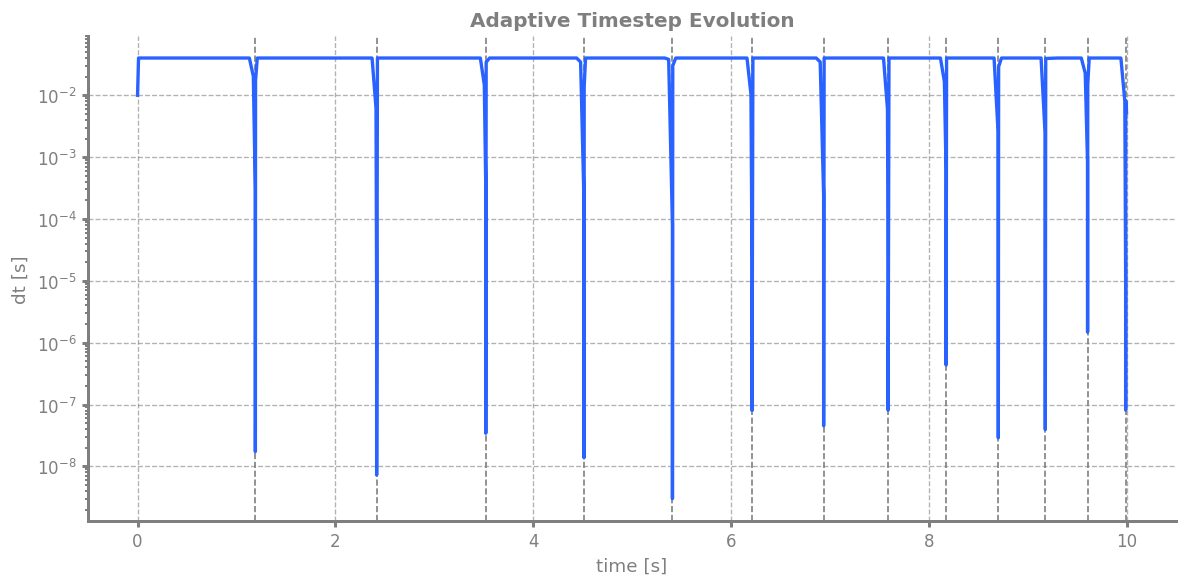

In [58]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True, dpi=120)
for t in E1: 
    ax.axvline(t, ls="--", lw=1, c="gray", label="Bounce Event" if t == list(E1)[0] else None)
# Plot the differences of time -> timesteps
ax.plot(time[:-1], np.diff(time), lw=2, color='#2962ff')
ax.set_yscale("log")
ax.set_ylabel("dt [s]")
ax.set_xlabel("time [s]")
ax.set_title("Adaptive Timestep Evolution")
ax.grid(True)
plt.show()